# Papers:
- [Deep Fake Detector](http://cs230.stanford.edu/projects_winter_2019/reports/15812450.pdf)

In [1]:
import os
import cv2
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [2]:
CLASSES_IDS = {
    'REAL': 0,
    'FAKE': 1
}

CLASSES_NAMES = {
    0: 'real',
    1: 'fake'
}

class DeepFakeDataset(Dataset):
    """Fake vs Real."""

    def __init__(self, root_dir, split='train', transform=None):
        assert split in ['train', 'test']
        
        self.__root_dir = root_dir
        self.__split = split
        self.__transform = transform

        self.__split_dir = os.path.join(root_dir, split)
        self.__classes = os.listdir(self.__split_dir)

        self.__image_labels = []
        self.__images = []

        for cls in self.__classes:
            for image in os.listdir(os.path.join(self.__split_dir, cls)):
                self.__image_labels.append(cls)
                self.__images.append(image)

        assert len(self.__images) == len(self.__image_labels)

    @property
    def split(self):
        return self.__split

    @property
    def num_classes(self):
        return len(self.__classes)

    def __len__(self):
        return len(self.__images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_label = self.__image_labels[idx]
        image_name = os.path.join(self.__root_dir,
                                  self.__split,
                                  image_label,
                                  self.__images[idx])
        
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.__transform:
            image = self.__transform(image)

        probs = np.zeros((self.num_classes, ))
        probs[CLASSES_IDS[image_label]] = 1

        return image, probs

In [3]:
def plt_dataset(dataset, indices, row_size=8, title=None):
    fig, ax = plt.subplots(nrows=math.ceil(len(indices) / row_size), ncols=row_size, figsize=(8, 8))

    if title:
        fig.suptitle(f'Fake vs. Real Dataset: {title}', fontsize=28)
    else:
        fig.suptitle('Fake vs. Real Dataset', fontsize=28)
    
    for i, index in enumerate(indices):
        image, probs = dataset[index]
        label_id = np.argmax(probs)

        if type(image) is torch.tensor:
            image = image.detach().cpu().numpy()
            image = image.transpose((1, 2, 0))

        grid_i = i // row_size
        grid_j = i % row_size

        ax[grid_i, grid_j].axis("off")
        ax[grid_i, grid_j].set_title(f"{CLASSES_NAMES[label_id]} ({label_id})")
        ax[grid_i, grid_j].imshow(image)

Split train
It contains 100000 images


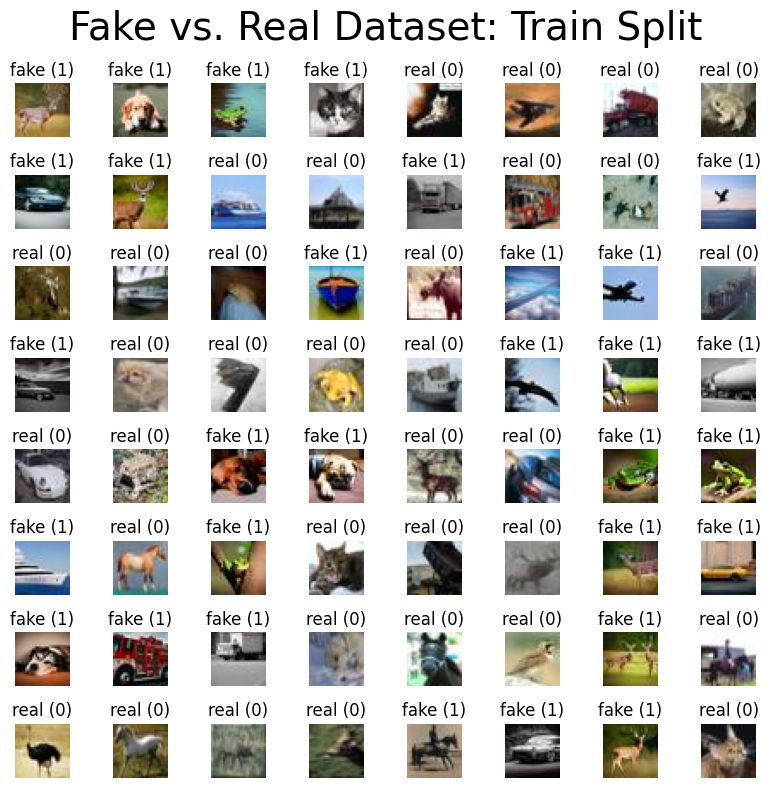

In [4]:
dataset = DeepFakeDataset('./temp/dataset')
indices = np.random.randint(0, len(dataset), 64)

print(f'Split {dataset.split}')
print(f'It contains {len(dataset)} images')

plt_dataset(dataset, indices, title='Train Split')
plt.tight_layout()
plt.show()

Split test
It contains 2181 images


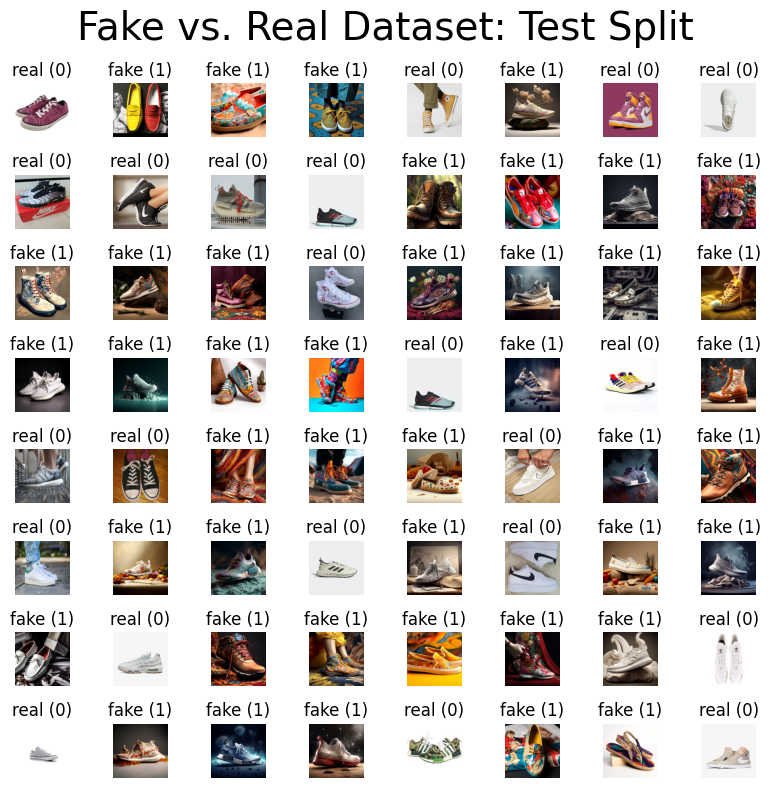

In [5]:
dataset = DeepFakeDataset('./temp/dataset', split='test')
indices = np.random.randint(0, len(dataset), 64)

print(f'Split {dataset.split}')
print(f'It contains {len(dataset)} images')

plt_dataset(dataset, indices, title='Test Split')
plt.tight_layout()
plt.show()

# Training+Validation utils

In [7]:
def normalise(inputs):
    mean = inputs.mean(dim=(2, 3)).unsqueeze(2).unsqueeze(3)
    std = inputs.std(dim=(2, 3)).unsqueeze(2).unsqueeze(3)
    
    return (inputs - mean) / (std + 1e-8)

def get_accuracy(trues, 
                 predictions):
    trues, predictions = trues.detach().cpu(), predictions.detach().cpu()
    return (np.argmax(trues, axis=1) == np.argmax(predictions, axis=1)).mean(dtype=torch.float32)

def train(model, 
          train_dataloader, 
          criterion, 
          optimizer, 
          scheduler, 
          grad_clip, 
          device='cpu'):
    model.to(device)
    model.train()

    losses = []
    accuracies = []
    
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.float()
        inputs = normalise(inputs)

        predictions = model(inputs)  
        loss = criterion(predictions, labels)
        loss.backward()

        if grad_clip: 
            torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        losses.append(loss.item())
        accuracies.append(get_accuracy(labels, predictions))

    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    return model, mean_accuracy, mean_loss

def validation(model,
               val_dataloader,
               criterion,
               device='cpu'):    
    model.to(device)
    model.eval()
    
    losses = []
    accuracies = []

    for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.float()
        inputs = normalise(inputs)
        
        with torch.no_grad():   
            predictions = model(inputs)

            loss = criterion(predictions, labels)

            losses.append(loss.item())
            accuracies.append(get_accuracy(labels, predictions))

    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    return mean_accuracy, mean_loss

In [8]:
def create_net(num_classes,
               model_type,
               pretrained):
    if pretrained and model_type == 'resnet18':
        weights = 'ResNet18_Weights.IMAGENET1K_V1'
    elif pretrained and model_type == 'resnet34':
        weights = 'ResNet34_Weights.IMAGENET1K_V1'
    elif pretrained and model_type == 'resnet50':
        weights = 'ResNet50_Weights.IMAGENET1K_V2'
    else:
        weights = None
    
    if model_type == 'resnet18':
        model = torchvision.models.resnet18(weights=weights)
    elif model_type == 'resnet34':
        model = torchvision.models.resnet34(weights=weights)
    elif model_type == 'resnet50':
        model = torchvision.models.resnet50(weights=weights)
    else:
        raise Exception(f'Unknown model type: {model_type}')

    num_inputs = model.fc.in_features
    model.fc = torch.nn.Linear(num_inputs, num_classes)
    return model

In [9]:
train_dataset = DeepFakeDataset('./temp/dataset', split='train', transform=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
]))
test_dataset = DeepFakeDataset('./temp/dataset', split='test', transform=v2.Compose([
    v2.Resize(32, 32),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
]))

In [10]:
train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS']) 
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

In [13]:
def save_state(epoch,
               config,
               model,
               optimizer,
               file_path="./best_state.pth"):
    state = {
    'epoch': epoch,
    'config': config,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    }
    
    torch.save(state, file_path)

# ResNet18 
- No Weights
- 70 epochs

In [6]:
config = dict()
config['MODEL'] = 'resnet18'
config['MODEL_PRETRAINED'] = False
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 64
# x.com/karpathy/status/801621764144971776
config['LR'] = 3e-4
config['GRAD_CLIP'] = 0.1
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 1e-4
config['NUM_EPOCHS'] = 70

In [11]:
model = create_net(num_classes=config['NUM_CLASSES'], model_type=config['MODEL'], pretrained=config['MODEL_PRETRAINED'])

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['LR'], weight_decay=config['WEIGHT_DECAY'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                config['LR'], 
                                                epochs=config['NUM_EPOCHS'], 
                                                steps_per_epoch=len(train_loader))

In [14]:
train_accuracy = []
train_loss = []

val_accuracy = []
val_loss = []

best_accuracy = 0 

for epoch in range(config['NUM_EPOCHS']):
    print(f"Epoch #{epoch} started.")
    
    model, t_acc, t_loss = train(model, train_loader, criterion, optimizer, scheduler, grad_clip=config['GRAD_CLIP'], device=config['DEVICE'])
    train_accuracy.append(t_acc)
    train_loss.append(t_loss)

    print(f"Train loss: {t_loss}, accuracy: {t_acc}")

    v_acc, v_loss = validation(model, test_loader, criterion, device=config['DEVICE'])
    val_accuracy.append(v_acc) 
    val_loss.append(v_loss)

    print(f"Validation loss: {v_loss}, accuracy: {v_acc}")

    if v_acc > best_accuracy:
        print(f"Saving best accuracy so far, {v_acc}")
        best_accuracy = v_acc
        save_state(epoch, config, model, optimizer, file_path=f"./temp/best_state_{v_acc:.2f}.pth")

Epoch #0 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [46:34<00:00,  1.79s/it]


Train loss: 0.577423541555783, accuracy: 0.6943777799606323


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:17<00:00,  2.21s/it]


Validation loss: 3.984399611200206, accuracy: 0.3946428596973419
Saving best accuracy so far, 0.3946428596973419
Epoch #1 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [43:05<00:00,  1.65s/it]


Train loss: 0.4483467700080237, accuracy: 0.7873380780220032


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:13<00:00,  2.10s/it]


Validation loss: 1.2799087341342654, accuracy: 0.39196428656578064
Epoch #2 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [43:04<00:00,  1.65s/it]


Train loss: 0.36099455092323945, accuracy: 0.8391714692115784


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:04<00:00,  1.85s/it]


Validation loss: 0.8777298705918448, accuracy: 0.4833928644657135
Saving best accuracy so far, 0.4833928644657135
Epoch #3 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [40:45<00:00,  1.56s/it]


Train loss: 0.2888364112499198, accuracy: 0.8761296272277832


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:02<00:00,  1.78s/it]


Validation loss: 0.9673914296286447, accuracy: 0.4570535719394684
Epoch #4 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [39:38<00:00,  1.52s/it]


Train loss: 0.23467285623648804, accuracy: 0.9016614556312561


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:06<00:00,  1.90s/it]


Validation loss: 1.1826748183795384, accuracy: 0.5406249761581421
Saving best accuracy so far, 0.5406249761581421
Epoch #5 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [35:56<00:00,  1.38s/it]


Train loss: 0.21028634074238806, accuracy: 0.9134076833724976


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.62s/it]


Validation loss: 1.738136905006, accuracy: 0.5723214149475098
Saving best accuracy so far, 0.5723214149475098
Epoch #6 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [26:39<00:00,  1.02s/it]


Train loss: 0.19912207347084068, accuracy: 0.9178562760353088


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.61s/it]


Validation loss: 0.8445157255445208, accuracy: 0.3537500202655792
Epoch #7 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [31:17<00:00,  1.20s/it]


Train loss: 0.192598521643898, accuracy: 0.9213051795959473


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:35<00:00,  1.02s/it]


Validation loss: 1.993783324105399, accuracy: 0.3946428596973419
Epoch #8 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [18:23<00:00,  1.42it/s]


Train loss: 0.1864481449570514, accuracy: 0.9239043593406677


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:35<00:00,  1.01s/it]


Validation loss: 1.102453659261976, accuracy: 0.2767857015132904
Epoch #9 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [31:38<00:00,  1.21s/it]


Train loss: 0.17777131006159771, accuracy: 0.9272032976150513


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.63s/it]


Validation loss: 1.5509734732764109, accuracy: 0.35723215341567993
Epoch #10 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [20:56<00:00,  1.24it/s]


Train loss: 0.16700965198506473, accuracy: 0.9327115416526794


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:35<00:00,  1.01s/it]


Validation loss: 1.2330115250178746, accuracy: 0.28258928656578064
Epoch #11 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [26:48<00:00,  1.03s/it]


Train loss: 0.15772307242885927, accuracy: 0.9374800324440002


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.62s/it]


Validation loss: 1.7625315495899745, accuracy: 0.0982142835855484
Epoch #12 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [25:42<00:00,  1.01it/s]


Train loss: 0.14682545499567487, accuracy: 0.9418286085128784


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:35<00:00,  1.02s/it]


Validation loss: 1.6604894229343958, accuracy: 0.3035714328289032
Epoch #13 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [23:16<00:00,  1.12it/s]


Train loss: 0.1400052157986816, accuracy: 0.9446277022361755


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:54<00:00,  1.56s/it]


Validation loss: 1.760782140493393, accuracy: 0.4995535612106323
Epoch #14 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [29:53<00:00,  1.15s/it]


Train loss: 0.1309244730012278, accuracy: 0.9490863084793091


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:55<00:00,  1.58s/it]


Validation loss: 1.474969916684287, accuracy: 0.46071428060531616
Epoch #15 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [33:21<00:00,  1.28s/it]


Train loss: 0.12224519039877832, accuracy: 0.9521753191947937


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.61s/it]


Validation loss: 1.7348744366850173, accuracy: 0.4915178716182709
Epoch #16 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [30:02<00:00,  1.15s/it]


Train loss: 0.11220420031407306, accuracy: 0.9559240937232971


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.63s/it]


Validation loss: 1.862249047415597, accuracy: 0.09098214656114578
Epoch #17 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [31:45<00:00,  1.22s/it]


Train loss: 0.10263392170241684, accuracy: 0.959632933139801


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.60s/it]


Validation loss: 1.6320103560175214, accuracy: 0.40758928656578064
Epoch #18 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [27:58<00:00,  1.07s/it]


Train loss: 0.09574952373794748, accuracy: 0.9628618955612183


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.62s/it]


Validation loss: 1.6318359238760811, accuracy: 0.1557142734527588
Epoch #19 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [29:20<00:00,  1.13s/it]


Train loss: 0.08506777404550694, accuracy: 0.9667206406593323


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:55<00:00,  1.59s/it]


Validation loss: 1.5374535339219229, accuracy: 0.38482141494750977
Epoch #20 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [32:26<00:00,  1.25s/it]


Train loss: 0.0790685437004763, accuracy: 0.9696996808052063


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:59<00:00,  1.69s/it]


Validation loss: 1.5766894391604833, accuracy: 0.3080357015132904
Epoch #21 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [35:16<00:00,  1.35s/it]


Train loss: 0.07238014065705226, accuracy: 0.9717490673065186


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.61s/it]


Validation loss: 1.2283618671553476, accuracy: 0.22187499701976776
Epoch #22 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [35:34<00:00,  1.37s/it]


Train loss: 0.06383419287809894, accuracy: 0.9762076139450073


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.65s/it]


Validation loss: 1.7811842475618636, accuracy: 0.12044642120599747
Epoch #23 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [36:47<00:00,  1.41s/it]


Train loss: 0.05961396132005344, accuracy: 0.9777771234512329


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:05<00:00,  1.87s/it]


Validation loss: 2.6670058782611576, accuracy: 0.3821428716182709
Epoch #24 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [33:23<00:00,  1.28s/it]


Train loss: 0.05347801203334791, accuracy: 0.9796364903450012


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:03<00:00,  1.83s/it]


Validation loss: 2.0324780566351754, accuracy: 0.11151786148548126
Epoch #25 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [33:00<00:00,  1.27s/it]


Train loss: 0.048458259122658304, accuracy: 0.9823156595230103


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.60s/it]


Validation loss: 1.88713549886431, accuracy: 0.23839285969734192
Epoch #26 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [36:21<00:00,  1.40s/it]


Train loss: 0.04561829896515947, accuracy: 0.9830453991889954


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:05<00:00,  1.88s/it]


Validation loss: 2.1565532411847794, accuracy: 0.13526785373687744
Epoch #27 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [37:38<00:00,  1.45s/it]


Train loss: 0.04268678719006831, accuracy: 0.9841450452804565


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:01<00:00,  1.76s/it]


Validation loss: 2.498438811302185, accuracy: 0.14812499284744263
Epoch #28 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [39:54<00:00,  1.53s/it]


Train loss: 0.038602021168881666, accuracy: 0.9857645630836487


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:22<00:00,  2.36s/it]


Validation loss: 2.08472318649292, accuracy: 0.12544642388820648
Epoch #29 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [43:45<00:00,  1.68s/it]


Train loss: 0.03585201289267318, accuracy: 0.986714243888855


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:16<00:00,  2.20s/it]


Validation loss: 1.8350048167364938, accuracy: 0.09767857193946838
Epoch #30 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [39:49<00:00,  1.53s/it]


Train loss: 0.034502144589449946, accuracy: 0.9871941208839417


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:09<00:00,  1.97s/it]


Validation loss: 1.955965484891619, accuracy: 0.18437500298023224
Epoch #31 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [37:29<00:00,  1.44s/it]


Train loss: 0.0314243644361905, accuracy: 0.9885736703872681


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:10<00:00,  2.01s/it]


Validation loss: 1.4164917026247297, accuracy: 0.41874998807907104
Epoch #32 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [40:37<00:00,  1.56s/it]


Train loss: 0.029364221466230606, accuracy: 0.989363431930542


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:05<00:00,  1.86s/it]


Validation loss: 2.0741563831056866, accuracy: 0.13205356895923615
Epoch #33 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [35:49<00:00,  1.38s/it]


Train loss: 0.02761817754843491, accuracy: 0.9897732734680176


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:34<00:00,  2.69s/it]


Validation loss: 2.3325888974325997, accuracy: 0.4178571403026581
Epoch #34 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:11<00:00,  1.47s/it]


Train loss: 0.024140646930722764, accuracy: 0.991492748260498


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:12<00:00,  2.08s/it]


Validation loss: 1.97805312701634, accuracy: 0.162410706281662
Epoch #35 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [37:59<00:00,  1.46s/it]


Train loss: 0.023000976858594736, accuracy: 0.9914227724075317


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:03<00:00,  1.82s/it]


Validation loss: 1.337919078554426, accuracy: 0.2883928716182709
Epoch #36 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [39:09<00:00,  1.50s/it]


Train loss: 0.02202494443846424, accuracy: 0.9922524690628052


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:58<00:00,  1.67s/it]


Validation loss: 2.1280898911612374, accuracy: 0.14848214387893677
Epoch #37 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:47<00:00,  1.49s/it]


Train loss: 0.019677264539363137, accuracy: 0.9932721257209778


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:09<00:00,  1.99s/it]


Validation loss: 1.570315478529249, accuracy: 0.17267856001853943
Epoch #38 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [42:33<00:00,  1.63s/it]


Train loss: 0.01857760524726659, accuracy: 0.9933221340179443


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:04<00:00,  1.84s/it]


Validation loss: 2.056917231423514, accuracy: 0.17053571343421936
Epoch #39 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [40:27<00:00,  1.55s/it]


Train loss: 0.01661172749907981, accuracy: 0.9941518902778625


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:07<00:00,  1.92s/it]


Validation loss: 2.1932083879198347, accuracy: 0.20125000178813934
Epoch #40 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:41<00:00,  1.49s/it]


Train loss: 0.016197114265910414, accuracy: 0.9942318201065063


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:04<00:00,  1.84s/it]


Validation loss: 2.048366175379072, accuracy: 0.2241964340209961
Epoch #41 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:56<00:00,  1.49s/it]


Train loss: 0.013415095428851274, accuracy: 0.9954514503479004


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:05<00:00,  1.88s/it]


Validation loss: 1.697973963192531, accuracy: 0.4151785671710968
Epoch #42 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:40<00:00,  1.48s/it]


Train loss: 0.01257785652200853, accuracy: 0.995591402053833


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:03<00:00,  1.82s/it]


Validation loss: 1.4233513423374722, accuracy: 0.4357142746448517
Epoch #43 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [37:33<00:00,  1.44s/it]


Train loss: 0.01164917929071811, accuracy: 0.9960112571716309


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:05<00:00,  1.88s/it]


Validation loss: 1.6830382244927542, accuracy: 0.4486607015132904
Epoch #44 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [35:31<00:00,  1.36s/it]


Train loss: 0.010081199074940284, accuracy: 0.9965111017227173


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.62s/it]


Validation loss: 1.8221253054482596, accuracy: 0.4959821403026581
Epoch #45 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [33:26<00:00,  1.28s/it]


Train loss: 0.009718899661995368, accuracy: 0.9966210722923279


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:00<00:00,  1.73s/it]


Validation loss: 2.203447307859148, accuracy: 0.1400892734527588
Epoch #46 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [35:03<00:00,  1.35s/it]


Train loss: 0.007235305444662541, accuracy: 0.9975507855415344


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.61s/it]


Validation loss: 2.2402640649250576, accuracy: 0.12937499582767487
Epoch #47 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [34:17<00:00,  1.32s/it]


Train loss: 0.0074361972550383215, accuracy: 0.9973908066749573


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.64s/it]


Validation loss: 1.8128641503197807, accuracy: 0.14723213016986847
Epoch #48 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [32:01<00:00,  1.23s/it]


Train loss: 0.0054830043555737645, accuracy: 0.9981805682182312


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.65s/it]


Validation loss: 1.93631101335798, accuracy: 0.15928570926189423
Epoch #49 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [34:47<00:00,  1.34s/it]


Train loss: 0.005037919102999864, accuracy: 0.9983005523681641


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.64s/it]


Validation loss: 2.4431093318121775, accuracy: 0.16017857193946838
Epoch #50 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [32:01<00:00,  1.23s/it]


Train loss: 0.004938226687749913, accuracy: 0.9983105659484863


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.60s/it]


Validation loss: 1.545498834337507, accuracy: 0.2465178668498993
Epoch #51 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [34:54<00:00,  1.34s/it]


Train loss: 0.0033497530393963113, accuracy: 0.9988503456115723


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.65s/it]


Validation loss: 2.006040520327432, accuracy: 0.2883928716182709
Epoch #52 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [31:17<00:00,  1.20s/it]


Train loss: 0.0034702869980694677, accuracy: 0.9988803863525391


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.62s/it]


Validation loss: 2.066664355141776, accuracy: 0.2299107164144516
Epoch #53 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [32:36<00:00,  1.25s/it]


Train loss: 0.002298731785841615, accuracy: 0.9992402195930481


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.64s/it]


Validation loss: 2.4528505827699387, accuracy: 0.3553571403026581
Epoch #54 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [31:26<00:00,  1.21s/it]


Train loss: 0.002249199900609699, accuracy: 0.9992102384567261


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.65s/it]


Validation loss: 2.085023844242096, accuracy: 0.31785714626312256
Epoch #55 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [32:36<00:00,  1.25s/it]


Train loss: 0.001324310810775718, accuracy: 0.9995701313018799


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:58<00:00,  1.67s/it]


Validation loss: 2.0472819907324653, accuracy: 0.3633928596973419
Epoch #56 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [34:31<00:00,  1.33s/it]


Train loss: 0.0013419077469655337, accuracy: 0.9995701313018799


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:58<00:00,  1.67s/it]


Validation loss: 2.053162639481681, accuracy: 0.13428570330142975
Epoch #57 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [32:53<00:00,  1.26s/it]


Train loss: 0.0008160660085671545, accuracy: 0.9997100830078125


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.65s/it]


Validation loss: 1.9235876083374024, accuracy: 0.24955357611179352
Epoch #58 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [34:41<00:00,  1.33s/it]


Train loss: 0.0006655459486747315, accuracy: 0.9997900724411011


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:57<00:00,  1.65s/it]


Validation loss: 1.6802000352314541, accuracy: 0.16651785373687744
Epoch #59 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [31:48<00:00,  1.22s/it]


Train loss: 0.0003916766306589888, accuracy: 0.9999200105667114


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:58<00:00,  1.68s/it]


Validation loss: 2.054869266918727, accuracy: 0.15937499701976776
Epoch #60 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [41:31<00:00,  1.59s/it]


Train loss: 0.0004591941922921011, accuracy: 0.9998200535774231


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:12<00:00,  2.08s/it]


Validation loss: 2.0599846567426408, accuracy: 0.21875
Epoch #61 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [40:23<00:00,  1.55s/it]


Train loss: 0.00011906129347259669, accuracy: 0.9999800324440002


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:09<00:00,  2.00s/it]


Validation loss: 2.1341695819582256, accuracy: 0.2276785671710968
Epoch #62 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:57<00:00,  1.50s/it]


Train loss: 0.0001300742025172392, accuracy: 0.9999899864196777


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:10<00:00,  2.01s/it]


Validation loss: 2.183370281968798, accuracy: 0.3544642925262451
Epoch #63 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [40:49<00:00,  1.57s/it]


Train loss: 0.00013639505466895072, accuracy: 0.999970018863678


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:09<00:00,  1.99s/it]


Validation loss: 2.09150733096259, accuracy: 0.27321428060531616
Epoch #64 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [40:51<00:00,  1.57s/it]


Train loss: 0.00017362089669484967, accuracy: 0.9999800324440002


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:07<00:00,  1.92s/it]


Validation loss: 2.08646183354514, accuracy: 0.375
Epoch #65 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:52<00:00,  1.49s/it]


Train loss: 6.20168135840058e-05, accuracy: 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:15<00:00,  2.16s/it]


Validation loss: 2.1202287912368774, accuracy: 0.34241071343421936
Epoch #66 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [38:44<00:00,  1.49s/it]


Train loss: 9.852805962110416e-05, accuracy: 0.9999800324440002


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:07<00:00,  1.92s/it]


Validation loss: 2.1999343855040414, accuracy: 0.2874999940395355
Epoch #67 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [41:07<00:00,  1.58s/it]


Train loss: 9.846194215285055e-05, accuracy: 0.9999899864196777


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:09<00:00,  1.99s/it]


Validation loss: 2.093801786218371, accuracy: 0.3477678596973419
Epoch #68 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [40:00<00:00,  1.54s/it]


Train loss: 0.00010230173613514569, accuracy: 0.9999800324440002


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:58<00:00,  1.68s/it]


Validation loss: 2.229357281752995, accuracy: 0.3330357074737549
Epoch #69 started.


100%|███████████████████████████████████████████████████████████████████████████████| 1563/1563 [39:06<00:00,  1.50s/it]


Train loss: 5.089382442886082e-05, accuracy: 1.0


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [01:07<00:00,  1.92s/it]


Validation loss: 2.192439687252045, accuracy: 0.2919642925262451


In [15]:
print(f"ResNet18 No Wieghts best acc {best_accuracy}")

ResNet18 No Wieghts best acc 0.5723214149475098


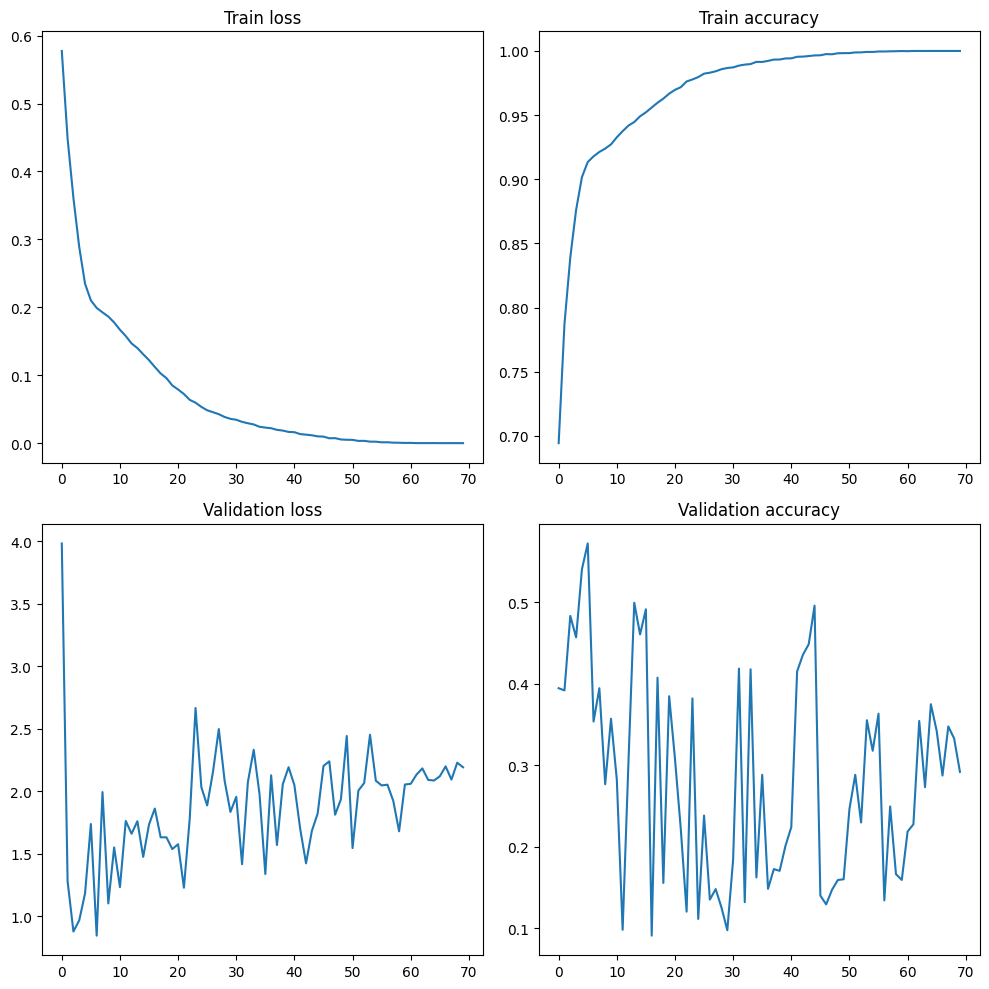

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].set_title("Train loss")
ax[0, 0].plot(train_loss)

ax[0, 1].set_title("Train accuracy")
ax[0, 1].plot(train_accuracy)

ax[1, 0].set_title("Validation loss")
ax[1, 0].plot(val_loss)

ax[1, 1].set_title("Validation accuracy")
ax[1, 1].plot(val_accuracy)

plt.tight_layout()
plt.show()